# Hands on: Validação de Modelos

Uma empresa do ramo alimentício tem mais de 20 mil colaboradores em todo o Brasil. Com o passar dos anos a empresa percebeu um aumento no custo do plano de saúde com seus colaboradores. Como forma de entender esse comportamento, a gerência de Benefícios e Bem Estar da Diretoria de Pessoas conduziu uma pesquisa interna com um grupo de 1.338 colaboradores sorteados aleatoriamente ao longo de um ano.

A gerência acredita que fatores como fumo e obesidade podem estar relacionados com o maior uso do plano de saúde, o que acaba elevando os custos. Portanto, os colaboradores da pesquisa responderam características pessoais como o Índice de Massa Corpórea (IMC), Qte de Filhos e se fazem uso de cigarros. Segue abaixo o dicionário dos dados:

#### Dicionário de dados

| Variável | Descrição |
| ------ | ------ |
| DtRef | Data de Referência quando a pesquisa com o colaborador foi realizada |
| Idade | Idade do colaborador |
| Sexo | Sexo do colaborador |
| IMC | Índice de Massa Corporal do colaborador |
| Qte_filhos | Qte de filhos que o colaborador tem |
| Fumante | Flag se o colaborador é fumante ou não fumante |
| Regiao | Região do Brasil onde o colaborador mora |
| Custo_Saude | Custo de Plano de Saúde que esse colaborador trouxe para a empresa 3 meses depois da Data de Referência|

Com base nessas informações, pede-se:

- **Desenvolver um modelo que estime os custos de saúde dos próximos 3 meses dos colaboradores**
- **Validar o modelo com técnicas Out of Sample, Out of Time e Validação Cruzada**
- **Qual sua conclusão a respeito do melhor tipo de validação para o problema? Qual sua estimativa para a medida de performance esperada do modelo quando for usado para prever o custo do plano de saúde?**







#### Importação das bibliotecas

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aed

#modelo a ser treinado
from sklearn import linear_model

#métrica de performance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#particionamento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

#### Importação da base de dados

In [2]:
df = pd.read_excel("/home/lucasmateus/dbt-projects/projetos_lucas/curso_preditiva/diagnosticos_modelo/base_custos_saude.xlsx")
df

,DtRef,Idade,Sexo,IMC,Qte_Filhos,Fumante,Regiao,Custo_Saude
0,202101,25,Masculino,26.220,0,Não,Nordeste,272.132080
1,202101,23,Masculino,17.385,1,Não,Norte,277.519215
2,202101,41,Masculino,21.780,1,Não,Sudeste,627.247720
3,202101,38,Masculino,37.050,1,Não,Nordeste,607.967150
4,202101,60,Feminino,24.530,0,Não,Sudeste,1262.989670
...,...,...,...,...,...,...,...,...
1333,202112,24,Masculino,31.065,0,Sim,Nordeste,3425.405335
1334,202112,43,Masculino,25.520,5,Não,Sudeste,1447.833015
1335,202112,19,Masculino,34.900,0,Sim,Centro,3482.865400
1336,202112,45,Masculino,30.360,0,Sim,Sudeste,6259.287309


#### 1) Análise Exploratória inicial

In [3]:
perfil_pp, perfil_sv = aed.gera_relatorios_aed(df=df,
                                               target_feat='Custo_Saude')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

                                             |          | [  0%]   00:00 -> (? left)

Report base_aed_sv.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [4]:
df.isnull().sum()

DtRef          0
Idade          0
Sexo           0
IMC            0
Qte_Filhos     0
Fumante        0
Regiao         0
Custo_Saude    0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DtRef        1338 non-null   int64  
 1   Idade        1338 non-null   int64  
 2   Sexo         1338 non-null   object 
 3   IMC          1338 non-null   float64
 4   Qte_Filhos   1338 non-null   int64  
 5   Fumante      1338 non-null   object 
 6   Regiao       1338 non-null   object 
 7   Custo_Saude  1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


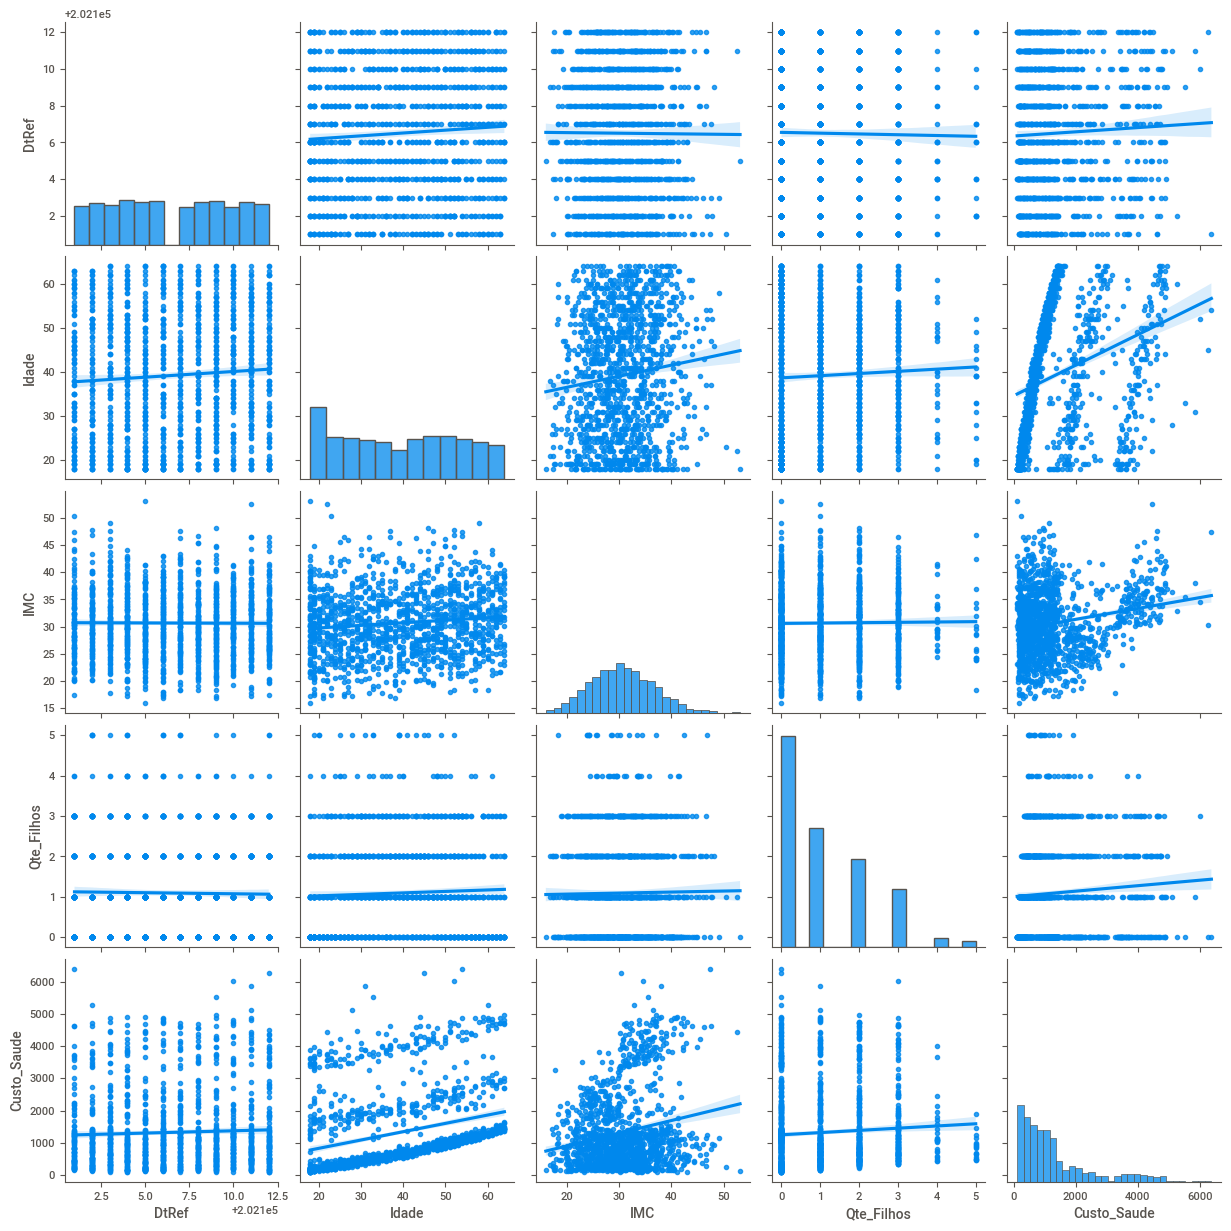

In [7]:
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')

sns.pairplot(df, kind='reg')

In [8]:
df_2 = pd.get_dummies(df, columns=['Sexo', 'Fumante', 'Regiao'])
df_2

,DtRef,Idade,IMC,Qte_Filhos,Custo_Saude,Sexo_Feminino,Sexo_Masculino,Fumante_Não,Fumante_Sim,Regiao_Centro,Regiao_Nordeste,Regiao_Norte,Regiao_Sudeste
0,202101,25,26.220,0,272.132080,0,1,1,0,0,1,0,0
1,202101,23,17.385,1,277.519215,0,1,1,0,0,0,1,0
2,202101,41,21.780,1,627.247720,0,1,1,0,0,0,0,1
3,202101,38,37.050,1,607.967150,0,1,1,0,0,1,0,0
4,202101,60,24.530,0,1262.989670,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,202112,24,31.065,0,3425.405335,0,1,0,1,0,1,0,0
1334,202112,43,25.520,5,1447.833015,0,1,1,0,0,0,0,1
1335,202112,19,34.900,0,3482.865400,0,1,0,1,1,0,0,0
1336,202112,45,30.360,0,6259.287309,0,1,0,1,0,0,0,1


#### 2) Análise de Correlação

In [14]:
# definindo a variável dependente
y = df_2['Custo_Saude']

# definindo as variáveis independentes
x = df_2.drop(['Custo_Saude'], axis=1)

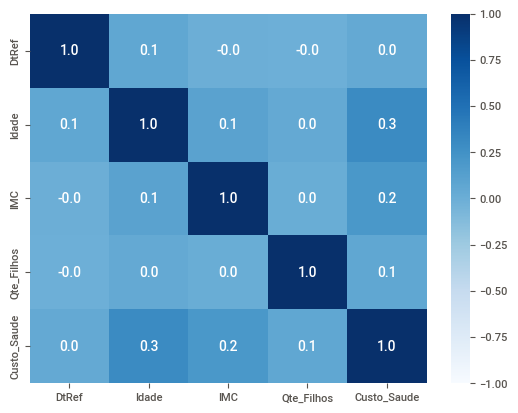

In [12]:
# Create the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix,
            cmap='Blues',
            vmin=-1, vmax=1,
            annot=True,
            fmt=".1f")  # Add annotations for coefficients
plt.show()

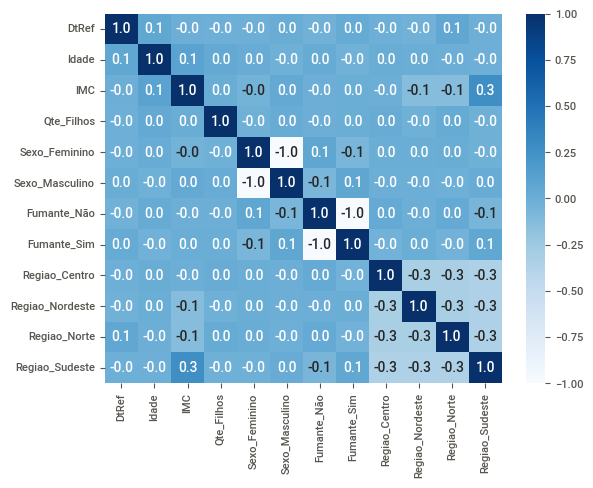

In [15]:
# Create the correlation matrix
correlation_matrix = x.corr()

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix,
            cmap='Blues',
            vmin=-1, vmax=1,
            annot=True,
            fmt=".1f")  # Add annotations for coefficients
plt.show()

#### 3) Desenvolvimento do modelo

In [16]:
model = linear_model.LinearRegression()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [18]:
model.fit(X_train, y_train)

LinearRegression()

##### 3.1) Validação Out of Sample

In [19]:
y_pred = model.predict(X_test)

In [22]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 413974.5991990292
R-squared: 0.7348789841695869
Mean Absolute Error (MAE): 454.95581767995554


##### 3.2) Validação Cruzada K-Fold

In [24]:
particoes = KFold(n_splits = 5)

In [27]:
particoes = KFold(n_splits = 5, shuffle = True, random_state = 42) 

In [ ]:
mse_train = []
mse_test = []
r2_train = []
r2_test = []

for train_index, test_index in particoes.split(x):
    
    # Separa a base    
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #Treina o modelo
    model.fit(X_train, y_train)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # AUC em Treino
    prob_train = model.predict_proba(X_train)[:,1]
    roc_train.append(roc_auc_score(y_train, prob_train))
    
    # AUC em Teste
    prob_test = modelo.predict_proba(X_test)[:,1]
    roc_test.append(roc_auc_score(y_test, prob_test))
    
    
resultado = pd.DataFrame({"AUC em Treino":roc_train, "AUC em Teste":roc_test})
resultado

##### 3.3) Validação Out of Time

##### 3.3) Validação Out of Time - Acompanhamento o R2 ao longo do tempo

#### 3.4) Afinal, qual a melhor validação para esse problema e qual o r2 geral do modelo ?